![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [8]:
# Importación de librerías
%matplotlib inline

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [9]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [11]:
# Celda 1
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Impresión variable a usar (Year)
j = 0
print(X_train.columns[j])

# División de la variable Year en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X_train.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X_train.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]


Year


In [12]:
# Definición de la función que calcula el gini index
def gini(y_train):
    if y_train.shape[0] == 0:
        return 0
    else:
        return 1 - (y_train.mean()**2 + (1 - y_train.mean())**2)

In [13]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)

In [14]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [15]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct)).tolist())
        #splits = np.unique(splits)[1:]
        splits = np.unique(splits)
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [16]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X_train, y_train, 10)

In [17]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X_train.iloc[:, j] < split

y_l = y_train.loc[filter_l]
y_r = y_train.loc[~filter_l]

In [18]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow( X, y, level, min_gain, max_depth, num_pct):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


In [19]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [20]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [21]:
y_pred = tree_predict(X_test, tree)

In [22]:
print('El F1 score del arbol de decision es de:',round(metrics.f1_score(y_pred, y_test),4))
print('El Accuracy del arbol de decision es de:',round(metrics.accuracy_score(y_pred, y_test),4))

El F1 score del arbol de decision es de: 0.896
El Accuracy del arbol de decision es de: 0.8724


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [23]:
# Celda 2
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


In [26]:
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
tree = DecisionTreeClassifier(max_depth=3, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_2 = X_train.iloc[sample, :]
    y_train_2 = y_train.iloc[sample, ]
    tree.fit(X_train_2, y_train_2)
    y_pred.iloc[:,i] = tree.predict(X_test)
    
#y_pred

In [27]:
for i in range(n_B):
    print('Árbol ', i, 'tiene un F1 score de: ', metrics.f1_score(y_pred.iloc[:,i], y_test))

Árbol  0 tiene un F1 score de:  0.900094696969697
Árbol  1 tiene un F1 score de:  0.8934659090909092
Árbol  2 tiene un F1 score de:  0.8968158965764902
Árbol  3 tiene un F1 score de:  0.8893213330090003
Árbol  4 tiene un F1 score de:  0.8830242510699001
Árbol  5 tiene un F1 score de:  0.8971098265895953
Árbol  6 tiene un F1 score de:  0.8984356759280878
Árbol  7 tiene un F1 score de:  0.874719800747198
Árbol  8 tiene un F1 score de:  0.8708375378405651
Árbol  9 tiene un F1 score de:  0.8846247267427738


In [28]:
y_pred_VM = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

In [29]:
print('El F1 score utilizando Bagging con 10 arboles es de:',round(metrics.f1_score(y_pred_VM, y_test),4))
print('El Accuracy utilizando Bagging con 10 arboles es de:',round(metrics.accuracy_score(y_pred_VM, y_test),4))

El F1 score utilizando Bagging con 10 arboles es de: 0.9034
El Accuracy utilizando Bagging con 10 arboles es de: 0.8825


Se observa un buen desempeño en el modelo, teniendo un F1 Score de 0.9 y Accuracy de 0.88. Se observa que al realizar Bagging se obtiene una mejora en el desempeño, puesto que al realizar un único arbol de decisión se obtuvo un F1 Score de 0.89 y al realizar Bagging se obtiene 0.9. En ambos casos se utilizaron arboles de decisión con un max_depth de 3.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [105]:
# Celda 3

import math

n_features=X_train.columns.shape[0]
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, random_state=123),n_estimators=10, max_features=int(math.log2(n_features)))
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
#X_train, X_test, y_train, y_test
print('El F1 score utilizando Bagging con librería con 10 arboles y log(n_features) es de:',round(metrics.f1_score(y_pred, y_test),4))
print('El Accuracy utilizando Bagging con librería con 10 arboles y log(n_features) es de:',round(metrics.accuracy_score(y_pred, y_test),4))

El F1 score utilizando Bagging con librería con 10 arboles y log(n_features) es de: 0.8972
El Accuracy utilizando Bagging con librería con 10 arboles y log(n_features) es de: 0.8721


Se observa un buen desempeño en el modelo, teniendo un F1 Score de 0.89 y Accuracy de 0.87. Se observa que al realizar Bagging con max_featres=log(n_features) se obtiene un resultado levemente peor, esto debido a que posiblemente se esté restringiendo bastante a cantidad de features a utilizar. Se utilizaron arboles de decisión con un max_depth de 3.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [106]:
# Celda 4


clf = RandomForestClassifier()

clf.fit(X_train,y_train)

prediccion=clf.predict(X_test)
acc=metrics.accuracy_score(prediccion, y_test)
print("Accuracy del modelo sin calibrar: "+str(acc))

Accuracy del modelo sin calibrar: 0.8435334872979214


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

([<matplotlib.axis.XTick at 0x240f73253f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

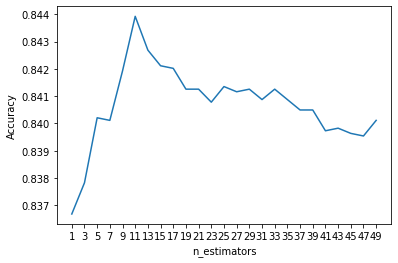

In [107]:
# Celda 5
# CALIBRACION N ESTIMATORS
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1, 50, 2)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.xticks(range(1,50,2))


Text(0, 0.5, 'Accuracy')

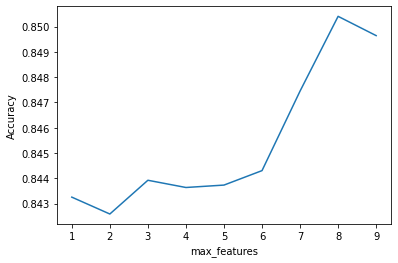

In [108]:
# CALIBRACION MAX FEATURES

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=11, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

(0.88261076703192, 6)


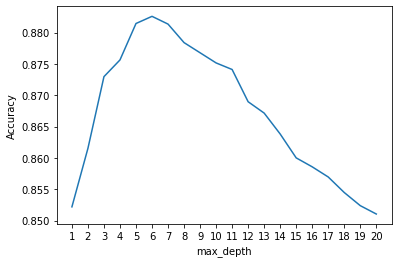

In [109]:
# CALIBRACION MAX DEPTH
max_depth_range = range(1, 21)

accuracy_scores = []

for depth in max_depth_range:
    rf=RandomForestClassifier(max_depth=depth,n_estimators=11, max_features=8, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())
    
%matplotlib inline
plt.plot(max_depth_range, accuracy_scores)
plt.xticks(range(1,21,1))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

print(sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

In [110]:
# CORRIDA MODELO CALIBRADO
clf = RandomForestClassifier(max_depth=6,n_estimators=11, max_features=8)

clf.fit(X_train,y_train)

prediccion=clf.predict(X_test)
acc=metrics.accuracy_score(prediccion, y_test)
print("Es posible observar una mejora importante del modelo al calibrar las variabes sugeridas generando el siguiente resultado")
print("Acuraccy del modelo calibrado: "+ str(acc))

feature_cols = data.columns.drop('HighPrice')
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

Es posible observar una mejora importante del modelo al calibrar las variabes sugeridas generando el siguiente resultado
Acuraccy del modelo calibrado: 0.8888568129330254


,feature,importance
4,M_CamryBase,0.000076
7,M_CamrySE,0.000730
5,M_CamryL,0.000991
3,M_Camry4dr,0.002465
2,M_Camry,0.009162
8,M_CamryXLE,0.011662
6,M_CamryLE,0.015652
0,Year,0.327344
1,Mileage,0.631918


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [111]:
# Celda 6
clf = XGBClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = metrics.accuracy_score(y_pred, y_test.values)

print('\nAccuracy = {0}'.format(accuracy))

print('\nEste modelo XGBoost, con los parametros default, obtiene un buen desempeño {:.4f}.'.format(accuracy))

print('\nParametros utilizados:',clf.get_xgb_params())



Accuracy = 0.8856812933025404

Este modelo XGBoost, con los parametros default, obtiene un buen desempeño 0.8857.

Parametros utilizados: {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eval_metric': None, 'gamma': 0, 'gpu_id': -1, 'grow_policy': 'depthwise', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_bin': 256, 'max_cat_to_onehot': 4, 'max_delta_step': 0, 'max_depth': 6, 'max_leaves': 0, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [112]:
# Celda 7


parameters = {           
              'learning_rate': [0.01, 0.02,0.03,0.05,0.10,0.20,0.30],
              'gamma': [i/10.0 for i in range(1,6)],
              'colsample_bytree': [i/10.0 for i in range(5,11)]
            }
clf = XGBClassifier()
skf = StratifiedKFold(n_splits=5)
n_iter_search = 10
search=RandomizedSearchCV(clf,param_distributions=parameters,n_iter=n_iter_search,
                          scoring='accuracy',n_jobs=-1,cv=skf)
search.fit(X_train, y_train)

best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

cal_accu = metrics.accuracy_score(y_pred, y_test.values)

column_results = [
    f"param_{name}" for name in search.param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = pd.DataFrame(search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)

print('\nEste modelo fue calibrado y los mejores parametros idenficados para colsample_bytree, gamma y learning_rate fueron:')
print('colsample_bytree calibrado:',best_model.get_xgb_params()['colsample_bytree'])
print('gamma calibrado:',best_model.get_xgb_params()['gamma'])
print('learning_rate calibrado:',best_model.get_xgb_params()['learning_rate'])

print('\nAl predecir el set de Test con este modelo calibrado se obtiene un accuracy de {:.4f}.  Mejor que el modelo sin calibracion.'.format(cal_accu))

print('\nEn los multiples escenarios se observa que un learning_rate pequeño genera un mejor score. Mientras que para gamma y col_sample_bytree parecen moverse en valores superiores de la grilla definida según: {0}'.format(search.param_distributions))
print('\nEn la siguiente tabla podemos observar como las diferentes configuraciones de parametros afectan el score para las {0} iteraciones usadas en la calibracion:'.format(n_iter_search))
cv_results



Este modelo fue calibrado y los mejores parametros idenficados para colsample_bytree, gamma y learning_rate fueron:
colsample_bytree calibrado: 0.8
gamma calibrado: 0.3
learning_rate calibrado: 0.05

Al predecir el set de Test con este modelo calibrado se obtiene un accuracy de 0.8877.  Mejor que el modelo sin calibracion.

En los multiples escenarios se observa que un learning_rate pequeño genera un mejor score. Mientras que para gamma y col_sample_bytree parecen moverse en valores superiores de la grilla definida según: {'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

En la siguiente tabla podemos observar como las diferentes configuraciones de parametros afectan el score para las 10 iteraciones usadas en la calibracion:


,param_learning_rate,param_gamma,param_colsample_bytree,mean_test_score,std_test_score,rank_test_score
1,0.05,0.3,0.8,0.882380,0.009571,1
9,0.01,0.3,0.7,0.881242,0.008503,2
3,0.01,0.5,1.0,0.879677,0.007646,3
7,0.02,0.2,0.5,0.878397,0.008522,4
6,0.01,0.5,0.5,0.876122,0.010257,5
2,0.3,0.4,0.5,0.875979,0.011686,6
4,0.2,0.5,0.8,0.874699,0.009455,7
5,0.2,0.3,1.0,0.874130,0.009059,8
0,0.3,0.2,0.6,0.872424,0.010438,9
8,0.3,0.2,1.0,0.872139,0.009577,10


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [115]:
# Celda 8
print("XGboost accuracy: "+str(cal_accu))
print("Random forest accuracy: "+str(acc))

XGboost accuracy: 0.8877020785219399
Random forest accuracy: 0.8888568129330254


Teniendo en cuenta el accuracy de ambos modelos, se puede evidenciar que el modelo con mayor desempeño fue el Random forest, sin embargo debido a que las diferencias de accuracy fueron pocas, realmente ambos modelos obtuvieron un desemeño similar.

Adicionalmente cabe mencionar que la calibración del modelo XGboost fue mucho más rápida considerando la utilización de la librería RandomizedSearchCV, la cual ahorró bastante tiempo de ejecución.